# Homework #2 - SHAP

---



Add your second homework to this folder.

Deadline 2021-03-26 EOD

Task: For a selected data set (you can use data from your project or data from Homework 1) prepare a knitr/jupiter notebook with the following points. Submit your results on GitHub to the directory Homeworks/H2.

TODO:

  1. For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)
  2. for some selected observations (two or three) from this dataset, calculate predictions for model (1)
  3. for observations selected in (2), calculate the decomposition of model prediction using SHAP, Break Down or both (packages for R: DALEX, iml, packages for python: shap, dalex).
  4. find two observations in the data set, such that they have different most important variables (e.g. age and gender are the most important for observation A, but race and class for observation B)
  5. (if possible) select one variable and find two observations in the data set such that for one observation this variable has a positive effect and for the other a negative effect
  6. train a second model (of any class, neural nets, linear, other boosting) and find an observation for which BD/shap attributions are different between the models
  7. Comment on the results for points (4), (5) and (6)

---


Late & rewritten.

First, a shap dependency will be needed.

In [ ]:
# Shap installation 
!pip install --upgrade --quiet shap

     |████████████████████████████████| 358kB 4.3MB/s 


### Pre-processing

---

Let's load the dataset:

In [2]:
import numpy as np
import pandas as pd 

df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


Next up, we need to pre-process the data, since the array above contains non-numerical values. 

In [3]:
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)   
df.head()

x = df.drop(['class'] , axis = 1)
y = df['class']

from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size = 0.25)

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)
print("x_test:\n", x_test, "\n")
print("y_test:\n", y_test, "\n")

x_train shape: (6093, 22) y_train shape: (6093,)
x_test shape: (2031, 22) y_test shape: (2031,)
x_test:
       cap-shape  cap-surface  cap-color  ...  spore-print-color  population  habitat
4158          2            0          3  ...                  1           5        4
6436          5            3          2  ...                  7           4        4
1510          5            0          8  ...                  3           0        1
7234          0            2          3  ...                  7           2        1
3119          5            0          8  ...                  3           4        0
...         ...          ...        ...  ...                ...         ...      ...
2908          5            0          3  ...                  2           5        0
463           5            3          9  ...                  3           2        3
7387          3            3          2  ...                  7           4        0
4294          2            0          3  ... 

### First Model

---

The data is pre-processed nicely. Now we'll need a model to train, i.e. XGBoost.

In [ ]:
import xgboost

model = xgboost.XGBClassifier().fit(x_train, y_train)
print("Model score on test set:", model.score(x_test, y_test))
print("Predictions for the first 3 observations: ", model.predict(x_test[:3]))

Model score on test set: 1.0
Predictions for the first 3 observations:  [1 1 0]


Accuracy is rather high, but given the dataset simplicity it is no surprise. NN-based model from HW1 reached similar score. 

Moving on - shap. But before that, an in-depth look into the selected observations would be in order.

In [ ]:
import shap

explainer = shap.Explainer(model, x_test)
shap_values = explainer(x_test)

print("shap_values.shape:", shap_values.shape)
print("shap values for the first 3 observations:\n", shap_values[:3])

shap_values.shape: (2031, 22)
shap values for the first 3 observations:
 .values =
array([[-2.25128297e-02, -7.79283717e-03, -7.49672402e-03,
         0.00000000e+00,  4.36389297e+00,  0.00000000e+00,
         5.75345284e-01, -2.35958197e-01,  5.84225780e-01,
         4.90195824e-02,  5.78780794e-01,  9.92087920e-01,
        -1.74860364e-02, -6.12291995e-02, -1.69472100e-01,
         0.00000000e+00,  0.00000000e+00,  2.50572840e-02,
         1.95320427e-03,  2.52994233e-01,  2.77550748e-01,
        -2.83240965e-02],
       [ 2.28680402e-02,  4.58402187e-04, -7.49672402e-03,
         0.00000000e+00,  4.44459180e+00,  0.00000000e+00,
         5.59240679e-01, -2.40083815e-01,  5.84225780e-01,
         4.90195824e-02,  5.78780794e-01,  1.07589699e+00,
         1.66273589e-02, -6.12291995e-02,  3.25869619e-01,
         0.00000000e+00,  0.00000000e+00,  2.50572840e-02,
         1.95320427e-03,  2.29988051e-01,  5.93863249e-02,
        -2.97848125e-02],
       [ 2.05821967e-01,  6.87603205e-0

And finally, explanations. Let's put the results into perspective.

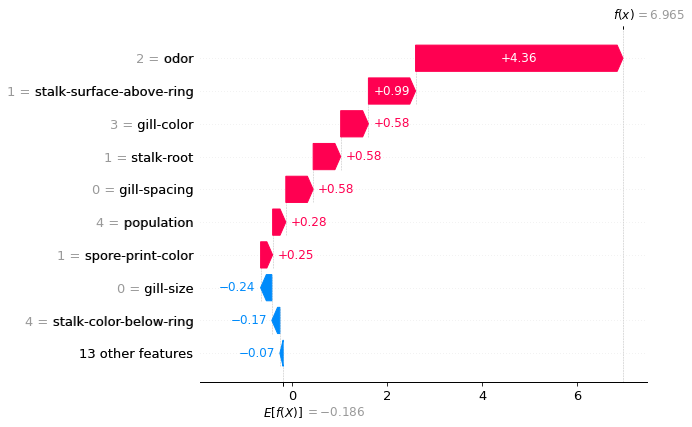

In [ ]:
shap.plots.waterfall(shap_values[0])

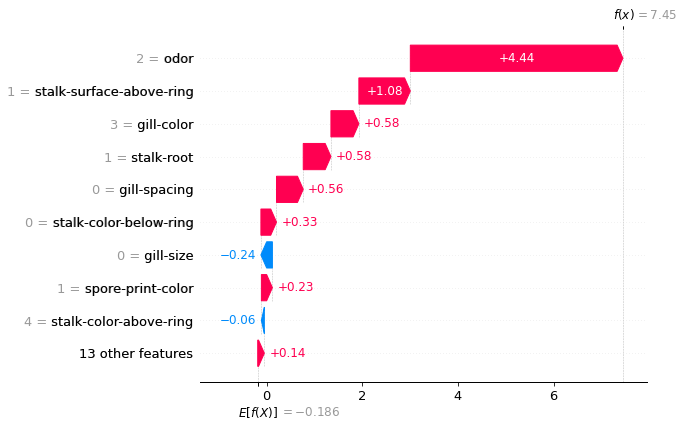

In [ ]:
shap.plots.waterfall(shap_values[1])

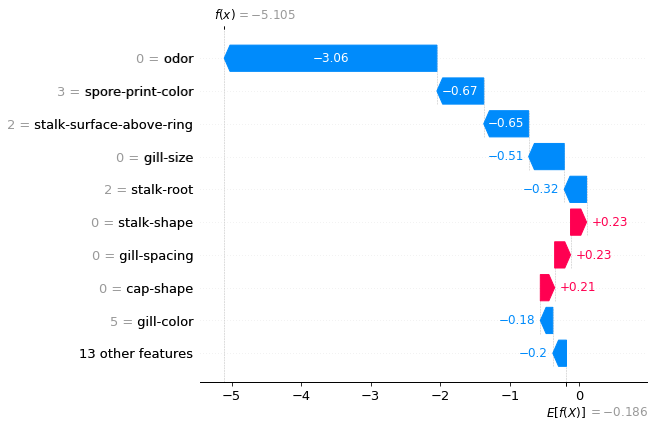

In [ ]:
shap.plots.waterfall(shap_values[2])

As we can see, in all of the above odor had the highest impact.
Also, notice that in the first two observations it affected output positively, and in the third - negatively. 

Let's see more general plot:


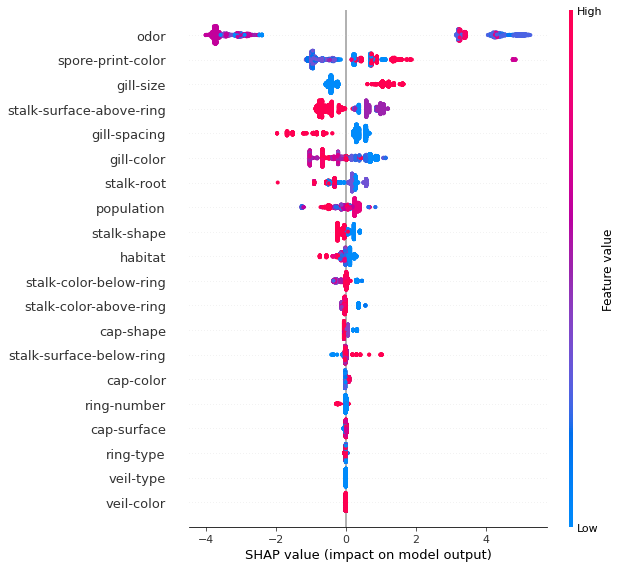

In [ ]:
shap.summary_plot(shap_values, x_test)

Although odor had the greatest impact in the majority of cases, 
we might be able to find few observations where spore-print-color turned out to be critical

In [ ]:
vals = [np.max(abs(shap_value.values)) for shap_value in shap_values]
importance = [np.argmax(abs(shap_value.values)) for shap_value in shap_values]
print(vals)
print(importance)

[4.363892969321459, 4.444591798167676, 3.056340482253581, 3.402345745675266, 3.6290349459461866, 3.056340482253581, 3.7456247889064254, 2.7145345177128912, 3.228483421318233, 3.4077955391816794, 3.766980491857976, 4.442253419365734, 4.34218815362081, 3.6290349459461866, 4.160461540687829, 3.7141004028357565, 3.310611037388444, 3.4990517962537706, 4.272168713752181, 3.437991996649653, 3.38835659371689, 3.665730043966323, 3.203954418040812, 3.2456323847547175, 4.7357132735475895, 3.7257417318411172, 3.228483421318233, 3.7141004028357565, 3.816847493816167, 3.228483421318233, 3.3809900427237154, 3.4780982874892654, 3.7102641762979327, 2.8323183869570494, 3.3433209899812937, 3.228483421318233, 3.6290349459461866, 3.3809900427237154, 3.203954418040812, 3.6614792886190117, 3.381728630568832, 3.635075251031667, 3.203954418040812, 3.6076792429946365, 3.635075251031667, 3.785441461466253, 3.7043860288895667, 3.752705701533705, 4.171275145802647, 3.228483421318233, 3.228483421318233, 4.790200439

As expected, importance list (filled with the highest shapley values) is almost filled with 4's (odor)

Can an index with a different leading feature be found?

In [ ]:
i = 0
for x in importance:
  if x !=4:
    break
  i += 1
print(i)

75


And there it is - one, where something different than smell was critical.

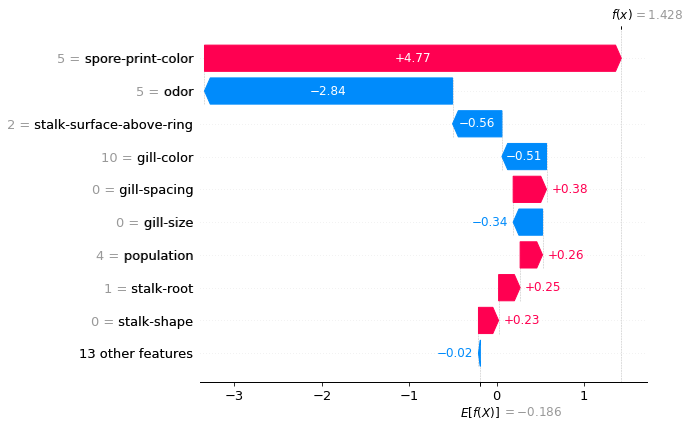

In [ ]:
shap.plots.waterfall(shap_values[75])

### Second Model

---

And now, for the last point, let's re-use some code from HW1 to train simple NN classifier

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=16, epochs=10)

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
381/381 [==============================] - 1s 2ms/step - loss: 0.7493 - accuracy: 0.6066
Epoch 2/10
381/381 [==============================] - 1s 2ms/step - loss: 0.5473 - accuracy: 0.7344
Epoch 3/10
381/381 [==============================] - 1s 1ms/step - loss: 0.4815 - accuracy: 0.7774
Epoch 4/10
381/381 [==============================] - 1s 2ms/step - loss: 0.4277 - accuracy: 0.8065
Epoch 5/10
381/381 [==============================] - 1s 1ms/step - loss: 0.3968 - accuracy: 0.8280
Epoch 6/10
381/381 [==============================] - 1s 2ms/step - loss: 0.3586 - accuracy: 0.8493
Epoch 7/10
381/381 [==============================] - 1s 2ms/step - loss: 0.3350 - accuracy: 0.8621
Epoch 8/10
381/381 [==============================] - 1s 1ms/step - loss: 0.3107 - accuracy: 0.8682
Epoch 9/10
381/381 [==============================] - 1s 2ms/step - loss: 0.2912 - accuracy: 0.8779
Epoch 10/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2028 - accuracy: 0.9350
T

Shap is a bit harder to use, so the plot below is differnt from the ones above. I'm using a solution based on an example from shap docks -

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html

In [24]:
def f(X):
    return model.predict(X).flatten()

explainer = shap.KernelExplainer(f, x_test.iloc[0:100])
shap_values = explainer.shap_values(x_test.iloc[0:100], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[0:100])

There were some issues with JS - for google colab which I'm using we need to enable it in each cell.

In [29]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[0:100])

The plot above helps to easily and interactively compare previously highlighted results with the ones from second model. Differences are quite interresting - for instance, in sample #75 in which previous model prioritized spore-print color current model ignored it altogether. Close instances #73 and #74 on the other hand ignore odor - another major feature for the previous model.